In [145]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf

from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.utils import draw_outputs
import matplotlib.pyplot as plt
import face_alignment
from scipy.spatial import Delaunay

In [2]:
flags.DEFINE_string('classes', './data/wddb_classes.names', 'path to classes file')
# flags.DEFINE_string('weights', './checkpoints/yolov3_tiny_wddb20200524-110249_033.ckpt', 'path to weights file')
flags.DEFINE_string('weights', './checkpoints/yolov3_tiny_wddb_step220200524-125021_012.ckpt', 'path to weights file')
flags.DEFINE_boolean('tiny', True, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

['yolov3']

In [358]:
# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size):
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))

    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine(src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_REFLECT_101)

    return dst

# Warps and alpha blends triangular regions from img1 and img2 to img
def morphTriangle(img1, img2, img, t1, t2, t, beta):
    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    r = cv2.boundingRect(np.float32([t]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = []
    t2Rect = []
    tRect = []

    for i in range(0, 3):
        tRect.append(((t[i][0] - r[0]), (t[i][1] - r[1])))
        t1Rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))

    # Get mask by filling triangle
    mask = np.zeros((r[3], r[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(tRect), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2Rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

    size = (r[2], r[3])
    warpImage1 = applyAffineTransform(img1Rect, t1Rect, tRect, size)
    warpImage2 = applyAffineTransform(img2Rect, t2Rect, tRect, size)

    # Alpha blend rectangular patches
    imgRect = (1.0 - beta) * warpImage1 + beta * warpImage2

    # Copy triangular region of the rectangular patch to the output image
    img[r[1]:r[1] + r[3], r[0]:r[0] + r[2]] = img[r[1]:r[1] + r[3], r[0]:r[0] + r[2]] * (1 - mask) + imgRect * mask

In [146]:
def transform_images(x_train, size):
    x_train = tf.image.resize_with_pad(x_train, size, size)
    x_train = (x_train-127.5) / 128
    return x_train

In [212]:
def get_landmarks(img_rgb):
    img = transform_images(img_rgb, FLAGS.size)
    boxes, scores, classes, nums = yolo(tf.expand_dims(img, 0))
    boxes_new = boxes[0].numpy()
    wh = np.flip(img.shape[0:2])
    boxes_new[:,0:2] *= wh
    boxes_new[:,2:4] *= wh
    bbox = [i for i in np.hstack([boxes_new,scores.numpy().transpose()]) if i[4] > 0.4]
    ldmks = detector.get_landmarks_from_image(img_rgb, bbox)
    return ldmks

def plot_tri_map(tri, points):
    plt.figure(figsize=(16,16))
    plt.triplot(-points[:,0], -points[:,1], tri.simplices)
    plt.plot(-points[:,0], -points[:,1], 'o')
    plt.show()

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, True)

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

cam = cv2.VideoCapture(0)
detector = face_alignment.FaceAlignment(landmarks_type=face_alignment.LandmarksType._2D)

I0524 16:13:39.069866 140024529631040 <ipython-input-3-cb6ee6bbf034>:11] weights loaded
I0524 16:13:39.070669 140024529631040 <ipython-input-3-cb6ee6bbf034>:14] classes loaded


In [20]:
 _, img_raw = cam.read()
img_raw = tf.image.resize_with_pad(img_raw, FLAGS.size, FLAGS.size).numpy().astype(np.uint8)

img_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
img = (img_rgb - 127.5) / 128
t1 = time.time()
boxes, scores, classes, nums = yolo(tf.expand_dims(img, 0))
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                       np.array(scores[0][i]),
                                       np.array(boxes[0][i])))

img_to_show = draw_outputs(img_raw.copy(), (boxes, scores, classes, nums), class_names)

I0524 16:18:33.998657 140024529631040 <ipython-input-20-78ea67372db9>:9] time: 0.13598990440368652
I0524 16:18:33.999420 140024529631040 <ipython-input-20-78ea67372db9>:11] detections:
I0524 16:18:34.002983 140024529631040 <ipython-input-20-78ea67372db9>:13] 	face, 0.9991151094436646, [0.3767699  0.28162614 0.65324736 0.6685971 ]


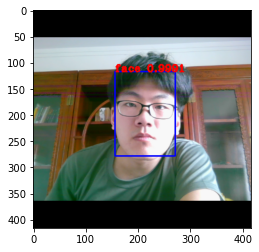

In [21]:
plt.imshow(cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB))

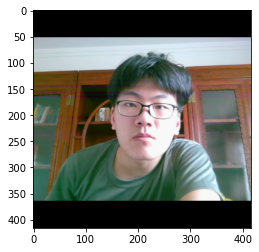

In [22]:
plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))

In [182]:
img = img_rgb.copy()
img = transform_images(img, FLAGS.size)
boxes, scores, classes, nums = yolo(tf.expand_dims(img, 0))

In [183]:
boxes_new = boxes[0].numpy()
wh = np.flip(img_raw.shape[0:2])
boxes_new[:,0:2] *= wh
boxes_new[:,2:4] *= wh

In [184]:
bbox = [i for i in np.hstack([boxes_new,scores.numpy().transpose()]) if i[4] > 0.4]

In [185]:
ldmks = detector.get_landmarks_from_image(img_rgb, bbox)

In [186]:
tmp = img_rgb.copy()
for face in ldmks:
    for x,y in face:
        cv2.circle(tmp, (int(x), int(y)), 1, (255, 0, 0), thickness=-1)

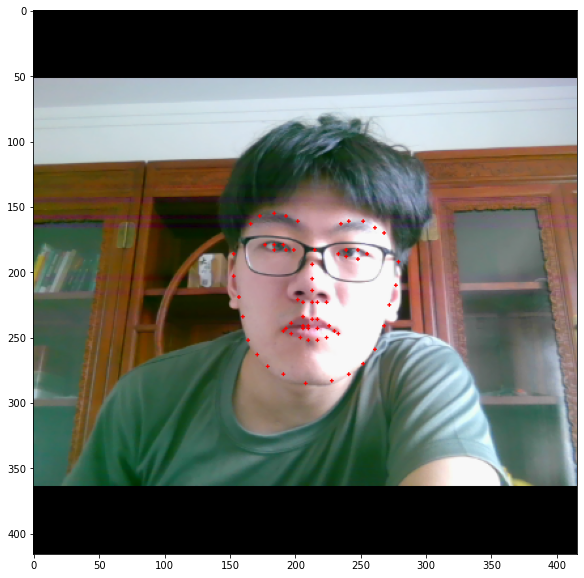

In [187]:
plt.figure(figsize=(20,10))
plt.imshow(tmp)

In [363]:
img1_raw = tf.image.decode_image(open('2.jpg', 'rb').read(), channels=3)
img2_raw = tf.image.decode_image(open('3.jpg', 'rb').read(), channels=3)

In [364]:
def get_border_points(shape, split_num=10):
    first = np.arange(split_num+1) * ((shape[0]-1) / split_num)
    second = np.arange(split_num+1) * ((shape[1]-1) / split_num)
    return np.hstack([np.stack([first, np.zeros(first.shape[0])]),
                        np.stack([np.zeros(second.shape[0]), second])[:,1:],
                        np.stack([first, np.ones(first.shape[0]) * (shape[1]-1)])[:,1:],
                        np.stack([np.ones(second.shape[0]) * (shape[0]-1), second])[:,1:-1]]).transpose()

In [375]:
img1 = tf.image.resize_with_pad(img1_raw, FLAGS.size, FLAGS.size).numpy()
img2 = tf.image.resize_with_pad(img2_raw, FLAGS.size, FLAGS.size).numpy()

points1 = np.vstack([get_landmarks(img1)[0], get_border_points(img1.shape)])
tri1 = Delaunay(points1)

points2 = np.vstack([get_landmarks(img2)[0], get_border_points(img2.shape)])
tri2 = Delaunay(points2)
#plot_tri_map(tri2, points2)
#plot_tri_map(tri1, points1)

# Read array of corresponding points
points = []
alpha = 0
beta = 1

# Compute weighted average point coordinates
for (x1, y1), (x2, y2) in zip(points1, points2):
    x = (1 - alpha) * x1 + alpha * x2
    y = (1 - alpha) * y1 + alpha * y2
    points.append((x, y))

In [385]:
# Allocate space for final output
result_img = np.zeros(img2.shape, dtype=img2.dtype)
triangle_list = tri1.simplices
# Read triangles from delaunay_output.txt
for x, y, z in triangle_list:
    t1 = [points1[x], points1[y], points1[z]]
    t2 = [points2[x], points2[y], points2[z]]
    t = [points[x], points[y], points[z]]

    # Morph one triangle at a time.
    morphTriangle(img1, img2, result_img, t1, t2, t, beta=1)

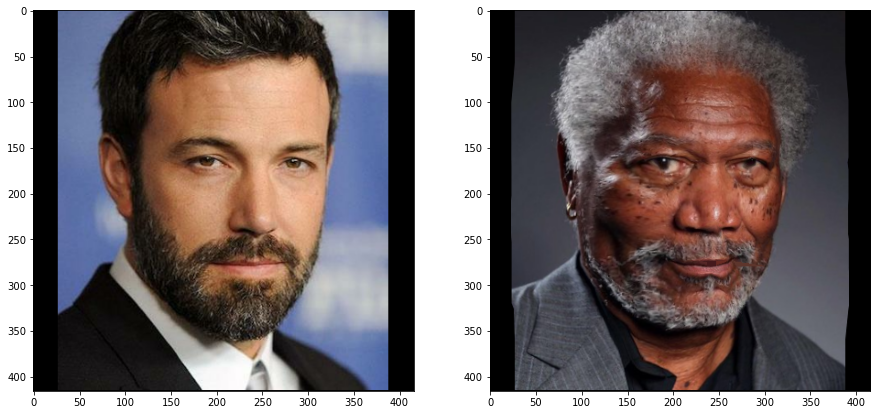

In [388]:
plt.figure(figsize=(15,30))
plt.subplot(1,2,1).imshow(img1.astype(np.uint8))
plt.subplot(1,2,2).imshow(result_img.astype(np.uint8))
plt.show()